# Netflix Stock Price Prediction (2002-2025)

## Loading Libraries & Packages

In [1]:
# Imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')


# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


# Try to import XGBoost; fallback to RandomForest if not available
try:
    from xgboost import XGBClassifier
except Exception:
    from sklearn.ensemble import RandomForestClassifier as XGBClassifier

## Importing Dataset

In [2]:
# Load dataset path if necessary)
csv_path = '/kaggle/input/netflix-stock-price-2002-2025/Netflix Inc. (NFLX) Stock Price 2002-2025.csv'

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    raise FileNotFoundError(f"CSV not found at {csv_path}. Please update the path.")


# Quick peek
print('Initial shape:', df.shape)
print('Columns:', df.columns.tolist())

Initial shape: (5729, 7)
Columns: ['Date', 'Open ', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [3]:
# Clean column names and basic dtype fixes
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Ensure Date column exists
if 'Date' not in df.columns:
    raise KeyError("No 'Date' column found in dataframe. Columns: {}".format(df.columns.tolist()))

# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

# Remove commas from numeric-like columns and convert them to numeric
numeric_like = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_like:
    if col in df.columns:
    # remove commas and possible dollar signs or spaces
        df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.replace('$', '', regex=False).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where Date or Close are missing
df = df.dropna(subset=['Date', 'Close']).reset_index(drop=True)

print('\nAfter cleaning:')
print(df.dtypes)
print(df.head())


After cleaning:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object
        Date  Open  High   Low  Close  Adj Close       Volume
0 2002-05-23  1.16  1.24  1.15   1.20       1.20  104790000.0
1 2002-05-24  1.21  1.23  1.20   1.21       1.21   11104800.0
2 2002-05-28  1.21  1.23  1.16   1.16       1.16    6609400.0
3 2002-05-29  1.16  1.16  1.09   1.10       1.10    6757800.0
4 2002-05-30  1.11  1.11  1.07   1.07       1.07   10154200.0


## Exploratory Data Analysis

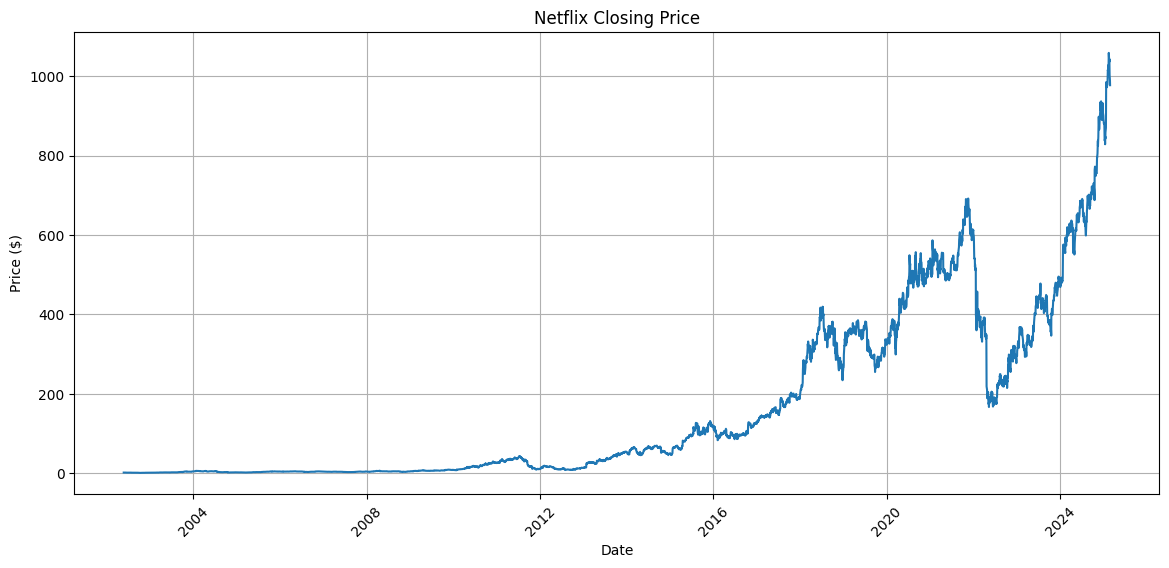

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.16,1.24,1.15,1.20,1.20,104790000.0
2002-05-24,1.21,1.23,1.20,1.21,1.21,11104800.0
2002-05-28,1.21,1.23,1.16,1.16,1.16,6609400.0
2002-05-29,1.16,1.16,1.09,1.10,1.10,6757800.0
2002-05-30,1.11,1.11,1.07,1.07,1.07,10154200.0
...,...,...,...,...,...,...
2025-02-19,1035.18,1045.00,1024.51,1043.33,1043.33,2600000.0
2025-02-20,1042.00,1045.00,1015.59,1024.54,1024.54,3111800.0
2025-02-21,1029.42,1032.38,999.39,1003.15,1003.15,3738700.0


In [4]:
# EDA plots (time series)
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Netflix Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Set Date as index for convenience
df.set_index('Date', inplace=False)

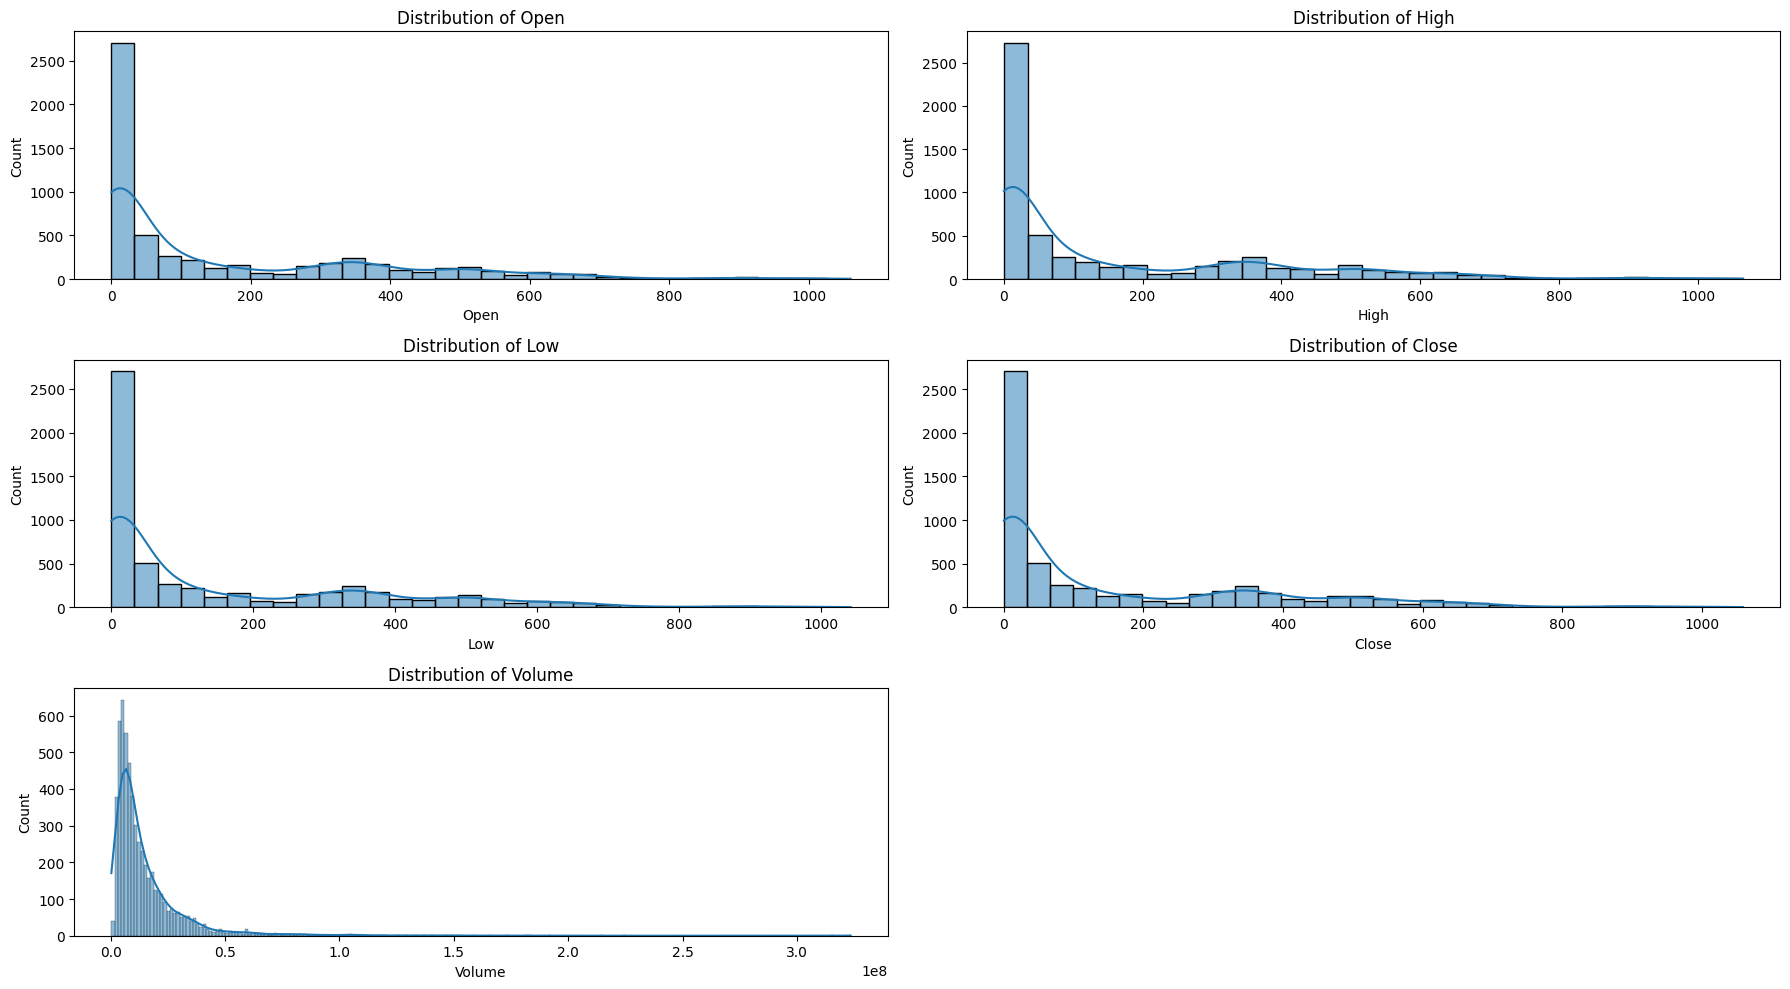

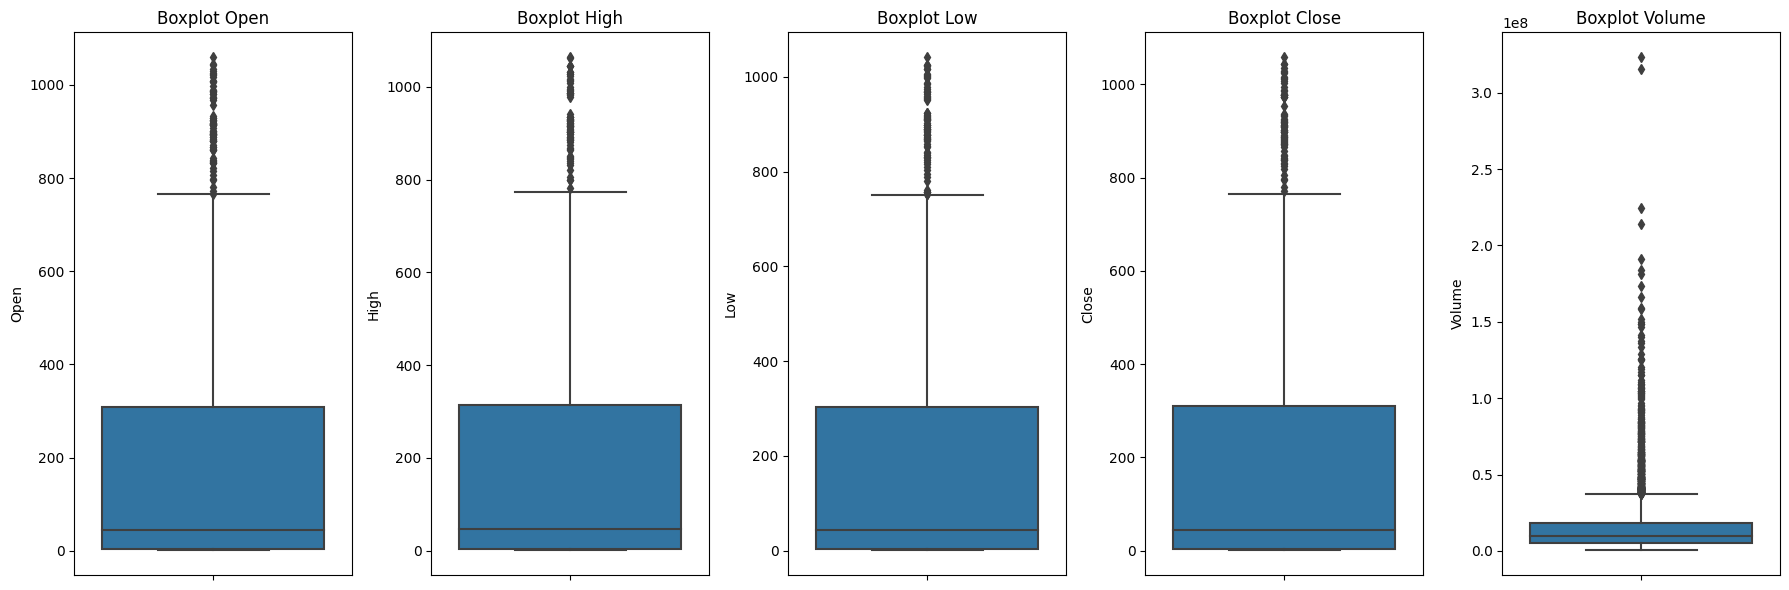

In [5]:
# Distribution and box plots for numeric features
features = [c for c in ['Open', 'High', 'Low', 'Close', 'Volume'] if c in df.columns]

plt.figure(figsize=(18, 10))
for i, col in enumerate(features):
    plt.subplot(3, 2, i+1)
    sb.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))
for i, col in enumerate(features):
    plt.subplot(1, len(features), i+1)
    sb.boxplot(y=df[col].dropna())
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

## Feature Engineering

In [7]:
# Feature engineering (date parts and flags)

# Ensure Date is datetime
if not np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract day/month/year
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# Quarter-end flag
df['is_quarter_end'] = (df['month'] % 3 == 0).astype(int)

# New features with valid column names
if 'Open' in df.columns and 'Close' in df.columns:
    df['open_close'] = df['Open'] - df['Close']
else:
    df['open_close'] = np.nan

if 'Low' in df.columns and 'High' in df.columns:
    df['low_high'] = df['Low'] - df['High']
else:
    df['low_high'] = np.nan

# Target: whether next day's close is higher than today's (binary)
df = df.sort_values('Date').reset_index(drop=True)
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
# Last row will have NaN target because of shift; drop it later when training

print(df[['Date','Close','open_close','low_high','is_quarter_end','target']].head())

        Date  Close  open_close  low_high  is_quarter_end  target
0 2002-05-23   1.20       -0.04     -0.09               0       1
1 2002-05-24   1.21        0.00     -0.03               0       0
2 2002-05-28   1.16        0.05     -0.07               0       0
3 2002-05-29   1.10        0.06     -0.07               0       0
4 2002-05-30   1.07        0.04     -0.04               0       1


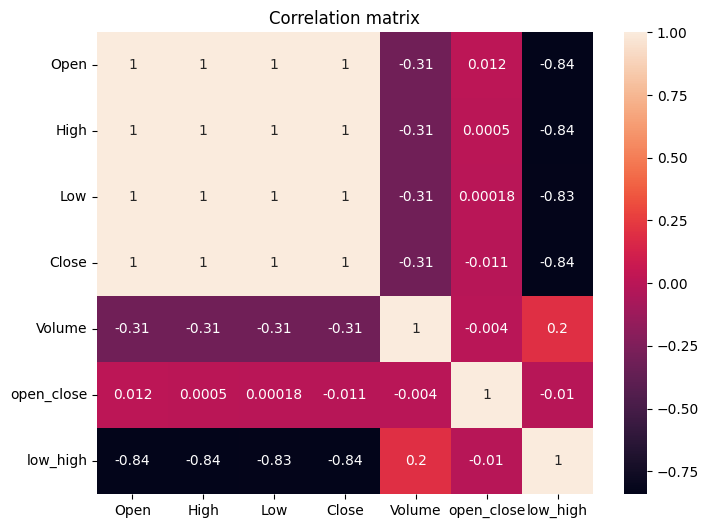


Missing values per column:
Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
day               0
month             0
year              0
is_quarter_end    0
open_close        0
low_high          0
target            0
dtype: int64


In [8]:
# CQuick checks and correlations
plt.figure(figsize=(8,6))
sb.heatmap(df[features + ['open_close','low_high']].corr(), annot=True)
plt.title('Correlation matrix')
plt.show()

print('\nMissing values per column:')
print(df.isnull().sum())

In [9]:
# Prepare feature matrix and labels for ML

# Select features that exist and are numeric
candidate_features = ['open_close', 'low_high', 'is_quarter_end']
X = df[candidate_features].copy()
Y = df['target'].copy()

# Drop rows with NaN in X or Y (last row will be dropped because target is NaN)
mask = X.notnull().all(axis=1) & Y.notnull()
X = X[mask]
Y = Y[mask]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train / validation split
X_train, X_valid, Y_train, Y_valid = train_test_split(
X_scaled, Y, test_size=0.1, random_state=2022, stratify=Y)

print('\nShapes:', X_train.shape, X_valid.shape)
print('Target distribution in train:', np.bincount(Y_train))
print('Target distribution in valid:', np.bincount(Y_valid))


Shapes: (5154, 3) (573, 3)
Target distribution in train: [2596 2558]
Target distribution in valid: [289 284]


## Model Training & Evaluation

In [10]:
# Train models and evaluate
models = [
    LogisticRegression(max_iter=1000),
    SVC(kernel='poly', probability=True),
    XGBClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

trained_models = []
for model in models:
    print('\nTraining', model)
    model.fit(X_train, Y_train)
    trained_models.append(model)

    # Predictions and probabilities
    proba_train = model.predict_proba(X_train)[:,1]
    proba_valid = model.predict_proba(X_valid)[:,1]

    print('Training ROC AUC:', metrics.roc_auc_score(Y_train, proba_train))
    print('Validation ROC AUC:', metrics.roc_auc_score(Y_valid, proba_valid))
    y_pred = model.predict(X_valid)
    print(classification_report(Y_valid, y_pred))

# Collect results into a table
results = []
for model in trained_models:
    name = model.__class__.__name__
    y_pred = model.predict(X_valid)

    acc = metrics.accuracy_score(Y_valid, y_pred)
    prec = metrics.precision_score(Y_valid, y_pred, zero_division=0)
    rec = metrics.recall_score(Y_valid, y_pred)
    r2 = metrics.r2_score(Y_valid, y_pred)
    mse = metrics.mean_squared_error(Y_valid, y_pred)

    results.append([name, acc, prec, rec, r2, mse])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "R²", "MSE"])
print("\nModel Comparison Table:\n")
print(results_df)


Training LogisticRegression(max_iter=1000)
Training ROC AUC: 0.5231736953826841
Validation ROC AUC: 0.5274197085627955
              precision    recall  f1-score   support

           0       0.52      0.73      0.61       289
           1       0.54      0.32      0.40       284

    accuracy                           0.53       573
   macro avg       0.53      0.53      0.50       573
weighted avg       0.53      0.53      0.51       573


Training SVC(kernel='poly', probability=True)
Training ROC AUC: 0.4998045347928069
Validation ROC AUC: 0.5
              precision    recall  f1-score   support

           0       0.51      0.28      0.36       289
           1       0.50      0.73      0.59       284

    accuracy                           0.50       573
   macro avg       0.51      0.50      0.48       573
weighted avg       0.51      0.50      0.48       573


Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

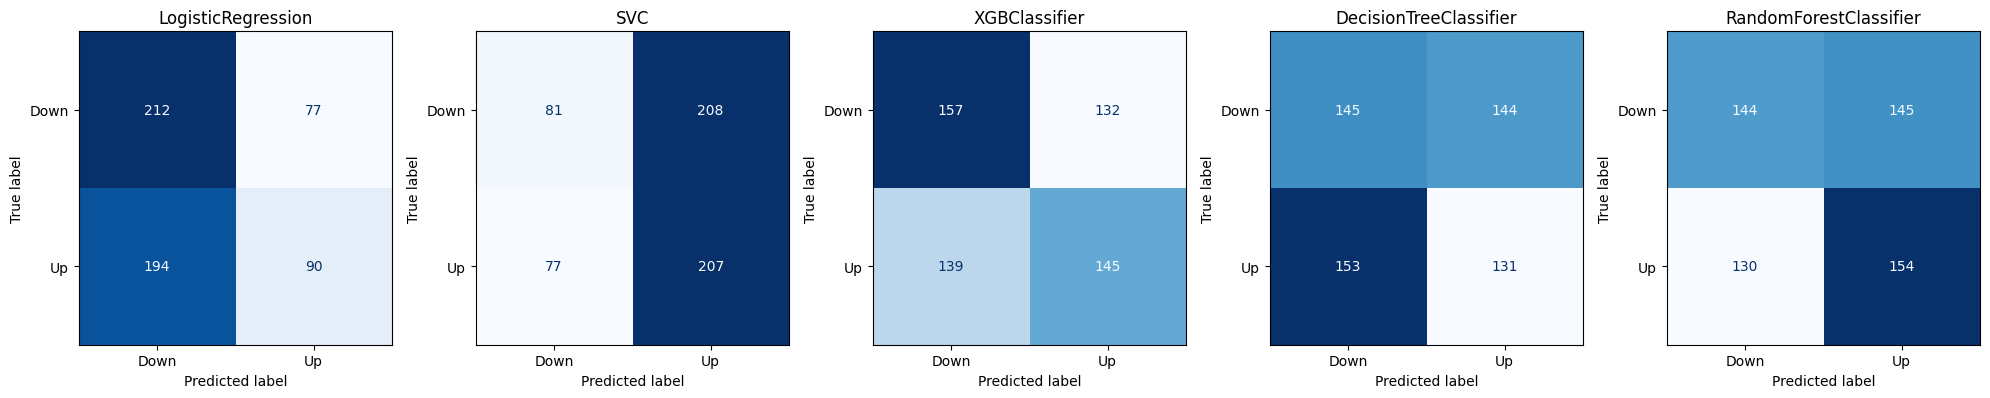

In [12]:
# Confusion matrix for the trained models

fig, axes = plt.subplots(1, len(trained_models), figsize=(20, 4))

for i, model in enumerate(trained_models):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_valid, Y_valid,
        display_labels=["Down", "Up"],  # label classes
        cmap="Blues",
        ax=axes[i],
        colorbar=False
    )
    axes[i].set_title(type(model).__name__)

plt.tight_layout()
plt.show()

In [13]:
# Save the cleaned dataframe
output_path = '/kaggle/working/netflix_cleaned.csv'
df.to_csv(output_path, index=False)
print(f'Cleaned dataframe saved to {output_path}')

Cleaned dataframe saved to /kaggle/working/netflix_cleaned.csv
